<a href="https://colab.research.google.com/github/macLeHoang/Exercises/blob/main/DIP/Untitled1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of LBP is to encode geometric features of an image by detecting edges, corners, raised or flat areas and hard lines; allowing us to generate a feature vector representation of an image, or group of images.

By encoding commonalities between images or of a single image of a given unknown class, we allow for comparison of their features, with that of another image. Through this comparison, we can determine the level of similarity between our target representation and an unseen image and can calculate the probability that the image presented is of the same variety or type as the target image. [1]

# Begin

In [ ]:
!wget https://vision.middlebury.edu/stereo/data/scenes2006/ThirdSize/zip-2views/ALL-2views.zip

folder = './data'
!unzip -q ALL-2views.zip -d $folder

--2022-07-22 06:20:39--  https://vision.middlebury.edu/stereo/data/scenes2006/ThirdSize/zip-2views/ALL-2views.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10792301 (10M) [application/zip]
Saving to: ‘ALL-2views.zip’

ALL-2views.zip      100%[===================>]  10.29M  12.7MB/s    in 0.8s    

2022-07-22 06:20:40 (12.7 MB/s) - ‘ALL-2views.zip’ saved [10792301/10792301]



In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os
from multiprocessing import Pool
from collections import defaultdict

# LBP and Variants

**Bilinear Interpolation**

Bilinear interpolation uses *4 nearest neighbor intensitie*s of offset to 
calculte final intensity

***bilinear interpolation formular:***

$weight_x = offset_X - int(offset_X)$

$weight_y = offsetY - int(offset_Y)$

$I = (1-weight_x)*(1-weight_y)*I_{top-left} + weight_x*(1-weight_y)*I_{top-right} + (1-weight_x)*weight_y*I_{bottom-left} + weight_x*(1 - weight_y)*I_{bottom-right}$


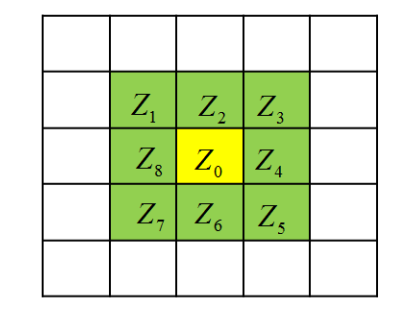

Reference: V. D. Nguyen, P. H. Nguyen and N. C. Debnath, "Local Binary Pattern and Census, Which One is Better in Stereo Matching," 2020 7th NAFOSTED Conference on Information and Computer Science (NICS), 2020, pp. 244-249, doi: 10.1109/NICS51282.2020.9335907.

## Local Binary Pattern

$LBP_{N, R} (z_c) = \sum_{n = 1}^{N} f(z_n, z_c) 2^n$

$\begin{align}
  f(z_n, z_c) = \left\{ 
    \begin{array}{cl} 
      1 & \text{for} & I(z_n) \geq I(z_c) \\
      0 & \text{for} & I(z_n) < I(z_c) 
    \end{array}
  \right.
\end{align} $

$\text{R is the radius of the neighborhood and N is the number of considered neighbor pixels, } z_c \text{ is center of local region.}$
$\text{N neighbor pixels can be located outside the image grid and their intensity values can be calculated by some interpolation techniques.}$

$\text{Coordinate calculation:}$
$(x_n, y_n) = [x_c + R\cos(\frac{2\pi n}{N}), y_c - R\sin(\frac{2\pi n}{N})]$

In [ ]:
def LBP_transform(img, npoints = 8, radius = 1.0, clock_wise = False, start_angle = 0.0, interpolation = 'bilinear'):
  '''
  Use to calculate local binary pattern of input image
    :param img: input image
    :param npoints: number of adjacent points used in calculation 
    :param radius: radius of circle 
    :param clock_wise: determine the direction of rotation
        if True: rotate clockwise - negative angle
        else: rotate counter-clockwise - positive angle
    :param start_angle: determine position of starting point 
    :param interpolation: should be 'nearest' or 'bilinear'
    
    :return LBP transform matrix 
  '''
  assert isinstance(npoints, int)
  assert interpolation in ('nearest', 'bilinear')

  imgH, imgW = img.shape[:2]
  lbpMatrix = np.zeros(shape = (imgH, imgW), dtype = np.uint)
  refX, refY = math.ceil(radius), math.ceil(radius)

  # Zeros padding input image
  padded = np.zeros(shape = (imgH + 2*math.ceil(radius), imgW + 2*math.ceil(radius)), dtype = np.uint)
  padded[math.ceil(radius):imgH + math.ceil(radius),
         math.ceil(radius):imgW + math.ceil(radius)] = img

  # Set up
  angle = 2 * math.pi / npoints # divide a circle into npoints-part equally
  rotateDirection = -1 if clock_wise else 1
  startAngle = start_angle / 180. * math.pi

  offset = []
  for i in range(npoints):
    offsetY = -radius * math.sin(startAngle + rotateDirection * angle * i)
    offsetX = radius * math.cos(startAngle + rotateDirection * angle * i)

    if interpolation == 'nearest':
      x = round(offsetX)
      y = round(offsetY)
      offset.append((y, x))

    elif interpolation == 'bilinear':
      offset.append((offsetY, offsetX))

  offset.reverse()
  assert len(offset) == npoints
  
  # nearest neightbor interpolation
  if interpolation == 'nearest':
    for (offsetY, offsetX) in offset:
      lbpMatrix = (lbpMatrix << 1) | (padded[refY + offsetY : refY + offsetY + imgH,
                                      refX + offsetX : refX + offsetX + imgW] >= img)
      
  # bilinear interpolation
  elif interpolation == 'bilinear':
    for (offsetY, offsetX) in offset:
      xmax, xmin = math.ceil(offsetX), math.floor(offsetX)
      ymax, ymin = math.ceil(offsetY), math.floor(offsetY)
      xWeight = offsetX - xmin
      yWeight = offsetY - ymin
      
      topLeft = padded[refY + ymin : refY + ymin + imgH,
                       refX + xmin : refX + xmin + imgW]
      topRight = padded[refY + ymin : refY + ymin + imgH,
                        refX + xmax: refX + xmax + imgW]
      bottomLeft = padded[refY + ymax : refY + ymax + imgH,
                          refX + xmin : refX + xmin + imgW]
      bottomRight = padded[refY + ymax : refY + ymax + imgH,
                           refX + xmax : refX + xmax + imgW]

      bilinearTop = (1 - xWeight) * topLeft + xWeight * topRight
      bilinearBottom = (1 - xWeight) * bottomLeft + xWeight * bottomRight

      bilinear = (1 - yWeight) * bilinearTop + yWeight * bilinearBottom

      lbpMatrix = (lbpMatrix << 1) | (bilinear >= img)
  return lbpMatrix

## Support Local Binary Pattern

$SLBP_{N, R}(z_c) = \otimes^{\Omega}_{\alpha = 0^{\circ}} LBP^{*}_{N, R}(z_c, z_{\alpha})$

$\begin{align}
LBP^{*}_{N, R}(z_c, z_{\alpha}) = \left \{
  \begin{array}{cl}
  LBP_{N, R}(z_c) & for & z_c = z_{\alpha} \\
  LBP\_S_{N, R}(z_c) & for & z_c \neq z_{\alpha}
  \end{array}
\right.
\end{align}$

$\text{Where } \alpha \in \Omega = [0^{\circ}, 45^{\circ}, 90^{\circ}, ..., 360^{\circ}] (w.r.t. \, N = 8) $

$\otimes \text{ is a bitwise concatenation, } Z_c \text{ is center of local region.}$ 

$\text{The auxilary function } LBP\_S_{N, R}(z_c) \text{ is calcuated by swapping } (z_c, z_{\alpha}) \text{ and preforming } LBP(z_c, z_{\alpha}) \\ \text{Define } z_{0^{\circ}} = z_c, e.g: z_{45^{\circ}} = z_3, z_{90^{\circ}} = z_2, z_{135^{\circ}} = z_1, z_{180^{\circ}} = z_8, z_{225^{\circ}} = z_7, z_{270^{\circ}} = z_6, z_{315^{\circ}} = z_5, z_{360^{\circ}} = z_4 \, for \, N = 8$

$\text{Reduction techniques:}$

$E.g: For\, N = 8, R = 1.\, \text{First, an 8-bit binary string is generated when } z_0 \text{ is the center pixel } (0^{\circ}), \text{A 7-bit binary string is then generated when } z_3 \text{ is the center pixel}
(45^{\circ}) \text{ because the relationship between z0 and z3 is already established. }$

$\text{ Second, a 6-bit binary string is generated when } z_2 \text{ is the center pixel } (90^{\circ}) \text{, because the relationship between }(z_2, z_0) \,and\, {(z_2, z_3)} \text{ is already established, etc.}$

$\text{Finally, we obtain the 36-bit SLBP presentation by concatenating all of the LBP binary strings at the eight directions in the following order: }$

$LBP \, at\, 0^{\circ}, LBP \, at\, 45^{\circ}, LBP \, at\, 90^{\circ},...,LBP \, at\, 360^{\circ}$


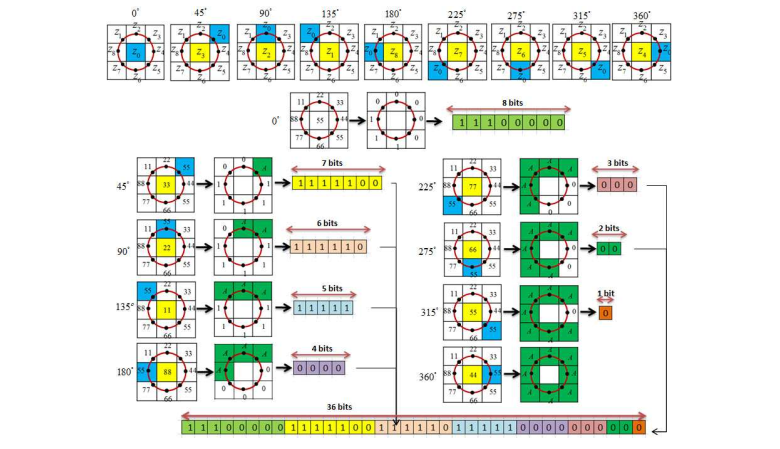

Reference: V. D. Nguyen, D. D. Nguyen, T. T. Nguyen, V. Q. Dinh and J. W. Jeon, "Support Local Pattern and its Application to Disparity Improvement and Texture Classification," in IEEE Transactions on Circuits and Systems for Video Technology, vol. 24, no. 2, pp. 263-276, Feb. 2014, doi: 10.1109/TCSVT.2013.2254898.

In [ ]:
def SLBP_transform(img, npoints = 8, r = 1, interpolation = 'nearest'):
  '''
    :param img: input image
    :param npoints: number of adjacent neighbors, N <= 10
    :param r: radius 
    :param interpolation: must be 'nearest' or 'bilinear'

    :return SLBP transform matrix
  '''
  
  assert npoints <= 10 # Maximum number of bits used to store uint number of numpy is 64 bit

  offset = math.ceil(r)
  imgH, imgW = img.shape[:2]
  paddedImg = np.zeros(shape = (imgH + 2*offset, imgW + 2*offset))
  paddedImg[offset : offset + imgH, offset : offset + imgW] = img

  angleRadian = 2 * math.pi / npoints # divide circle into n-points part equally
  offsetPoints = []
  for i in range(1, npoints + 1):
    x = r * math.cos(i * angleRadian)
    y = -r * math.sin(i * angleRadian)
    offsetPoints.append((y, x)) # (angles of 45, 90, 135, ..., 360)
  
  slbpMatrix = np.zeros(shape = (imgH, imgW), dtype = np.uint64)

  if interpolation == 'nearest':
    for idx in range(npoints):
      if idx == 0:
        u_, v_ = (0, 0)
      else:
        u, v = offsetPoints[idx - 1]
        u_, v_ = round(u), round(v)
      subRegion = paddedImg[offset + u_ : offset + u_ + imgH, offset + v_ : offset + v_ + imgW]

      for (uu, vv) in offsetPoints[idx:]:
        uu_, vv_ = round(uu), round(vv)
        slbpMatrix = slbpMatrix << 1 | (subRegion <= paddedImg[offset + uu_ : offset + uu_ + imgH,
                                                               offset + vv_ : offset + vv_ + imgW])
  elif interpolation == 'bilinear':
    bilinear = np.zeros(shape = (imgH, imgW, npoints))
    for idx, (u, v) in enumerate(offsetPoints):
      umax, vmax = math.ceil(u), math.ceil(v)
      umin, vmin = math.floor(u), math.floor(v)
      weightU = u - umin
      weightV = v - vmin

      tl = (1 - weightV) * paddedImg[offset + umin : offset + umin + imgH,
                                      offset + vmin : offset + vmin + imgW]

      tr = weightV * paddedImg[offset + umin : offset + umin + imgH,
                               offset + vmax : offset + vmax + imgW] 

      bl = (1 - weightV) * paddedImg[offset + umax : offset + umax + imgH,
                                     offset + vmin : offset + vmin + imgW]

      br = weightV * paddedImg[offset + umax : offset + umax + imgH,
                               offset + vmax : offset + vmax + imgW]  
      
      bilinear[..., idx] = (1 - weightU)*(tl + tr) + weightU*(bl + br) # Assign bilinear value correponding to direction
                                                                       # e.g. idx = [0, 1, 2, 3, 4, 5, 6, 7] respectively corresponding to 
                                                                       # direction [45, 90, 135, 180, 225, 270, 315, 360]

    for idx in range(npoints):
      for idx2 in range(idx, npoints):
        if idx == 0:
          slbpMatrix = slbpMatrix << 1 | (img <= bilinear[..., idx2]) # LBP with Zc if direction is 0
        else:
          slbpMatrix = slbpMatrix << 1 | (bilinear[..., idx - 1] <= bilinear[..., idx2]) # Else swapping each value then doing LBP

  return slbpMatrix

## Local Ternary Pattern

$LTP_{N, R, t} (z_c) = \sum_{n = 1}^{N} f(z_n, z_c, t) 2^n$

$\begin{align}
f(z_n, n_c, t) = \left\{
    \begin{array}{cl}
    1 & \text{for} & z_n \geq z_c + t \\
    0 & \text{for} & |z_n - z_c| < t \\
    -1 & \text{for} & z_n \leq z_c - t
    \end{array}
  \right.
\end{align}$

$with \, z_c \text{ is center of local region}$

In [ ]:
def LTP_transform(img, window_size = 3, threshold = 1.0):
  '''
  Use to calculate local ternary pattern of input image
    :param img: input image
    :param window_size: use to consider neighborhood
    :param threshold: float

    :return LTP transform matrix 
  '''

  imgH, imgW = img.shape[:2]
  offset = window_size // 2
  
  paddedImg = np.zeros(shape = (imgH + offset * 2, imgW + offset * 2))
  paddedImg[offset : offset + imgH, 
            offset : offset + imgW] = img
  
  offsetList = [(u, v) for u in range(-offset, offset + 1) \
                       for v in range(-offset, offset + 1) \
                       if not (u == 0 and v == 0)]
  
  ltpPositive = np.zeros(shape = (imgH, imgW), dtype = np.uint)
  ltpNegative = np.zeros(shape = (imgH, imgW), dtype = np.uint)

  for (dy, dx) in offsetList:
    mask = paddedImg[offset + dy : offset + dy + imgH,
                     offset + dx : offset + dx + imgW]
    ltpPositive = (ltpPositive << 1) | (mask >= (img + threshold))
    ltpNegative = (ltpNegative << 1) | (mask <= (img - threshold))
  
  ltpMatrix = np.concatenate([ltpPositive[..., np.newaxis], ltpNegative[..., np.newaxis]], axis = -1)

  return ltpMatrix

## Local Derivative Pattern

$ LDP_{\beta} ^{('')}(Z_n) = \otimes_{n = 1}^{N} s(I_{\beta}^{(')}(Z_0), I_{\beta}^{(')}(Z_n)) $

$ I_{\beta}^{(')}(Z_0) = I(Z_0) - I(Z_n)$

$\otimes \, \text{ is bitwise concatenation, } Z_0 \text{ is center of local region.}$

$ \begin{align}
s(I_{\beta}^{(')}(Z_0), I_{\beta}^{(')}(Z_n)) = \left \{
  \begin{array}{cl}
    0 & for & I_{\beta}^{(')}(Z_0) * I_{\beta}^{(')}(Z_n) > 0 \\
    1 & for & I_{\beta}^{(')}(Z_0) * I_{\beta}^{(')}(Z_n) \leq 0
  \end{array}
\right.
\end{align} $

$\text{Where} \, \beta \in [0^{\circ}, 45^{\circ}, 90^{\circ}, 135^{\circ}] \text{ and n} \in [4, 3, 2, 1] \, \text{respectively,} \,\text{N is total number of invole neighbors}.$

In [ ]:
def LDP_transform (img):
  '''
  Use in calculate local derivative pattern of input image
    :param img: input image

    :return LDP transform matrix
  '''
  translateList = [(0, 1), (-1, 1), (-1, 0), (-1, -1)]  # respectively correspoding to angle of 0, 45, 90, 135 
  offset = 1

  imgH, imgW = img.shape[:2]
  paddedImg = np.zeros(shape = (imgH + 1, imgW + 2))
  paddedImg[1:, 1:-1] = img

  # offsetList = [(u, v) for u in range(-1, 2) for v in range(-1, 2) if not(u == 0 and v == 0)]
  offsetList = [(1, 1), (1, 0), (1, -1), (0, -1)]
  ldpMatrix = np.zeros(shape = (imgH, imgW), dtype = np.uint)

  for (dy, dx) in translateList:
    firstDerivative = img - paddedImg[offset + dy : offset + dy + imgH,
                                      offset + dx : offset + dx + imgW]

    paddedFirstDerivative = np.zeros(shape = (imgH + 2, imgW + 2))
    paddedFirstDerivative[1 : -1, 1 : -1] = firstDerivative

    for (u, v) in offsetList:
      mask = firstDerivative * paddedFirstDerivative[offset + u : offset + u + imgH,
                                                     offset + v : offset + v + imgW]
      ldpMatrix = (ldpMatrix << 1) | (mask <= 0)
  return ldpMatrix

## Local Tetra Pattern

$ LTrP^{(n)}(Z_0) = \otimes_{p = 1}^{P}f_{LTrP}(I_{LTrP}^{(n-1)}(Z_0),I_{LTrP}^{(n-1)}(Z_p)) $

$\begin{align}
f_{LTrP}(I_{LTrP}^{(n-1)}(Z_0),I_{LTrP}^{(n-1)}(Z_p)) = \left \{
  \begin{array}{cl}
    0 & \text{for } I_{LTrP}^{(n-1)}(Z_0) = I_{LTrP}^{(n-1)}(Z_p) \\
    I_{LTrP}^{(n-1)}(Z_p) & \text{for } otherwise 
  \end{array}
\right.
\end{align}$

$\begin{align} 
I_{LTrP}^{(1)}(Z_0) = \left \{
  \begin{array}{cl}
    1 & for & I_{0^{\circ}}^{(1)}(Z_0) \geq 0 \text{ and } I_{90^{\circ}}^{(1)}(Z_p) \geq 0 \\
    2 & for & I_{0^{\circ}}^{(1)}(Z_0) < 0 \text{ and } I_{90^{\circ}}^{(1)}(Z_p) \geq 0 \\
    3 & for & I_{0^{\circ}}^{(1)}(Z_0) < 0 \text{ and } I_{90^{\circ}}^{(1)}(Z_p) < 0 \\
    4 & for & I_{0^{\circ}}^{(1)}(Z_0) \leq 0 \text{ and } I_{90^{\circ}}^{(1)}(Z_p) < 0 \\
  \end{array}
\right.
\end{align}$

$ I_{0^{\circ}}^{(1)}(Z_0) = I(Z_4) - I(Z_0) $

$ I_{90^{\circ}}^{(1)}(Z_0) = I(Z_2) - I(Z_0) $

$ \text{Where P is the number of neighboring pixels, } \otimes \, \text{is the bitwise concatenation and } Z_0 \, \text{is the center pixel in the local region} $

In [ ]:
def LTrP_transform(img, window_size = 3):
  offset = window_size // 2
  imgH, imgW = img.shape[:2]

  paddedImg = np.zeros(shape = (imgH + offset, imgW + offset))
  paddedImg[offset : offset + imgH,
             : imgW] = img
  
  dX = paddedImg[offset : offset + imgH,
                 offset : offset + imgW] - img # Horizontal First Derivative
  dY = paddedImg[:imgH, :imgW] - img # Vertical First Derivative

  mask1 = (dX >= 0) & (dY >= 0) 
  mask2 = (dX < 0)  & (dY >= 0)
  mask3 = (dX < 0)  & (dY < 0)
  mask4 = (dX >= 0) & (dY < 0)

  directionOfCenter = np.full(shape = (imgH, imgW), fill_value = 1) * mask1 +\
                      np.full(shape = (imgH, imgW), fill_value = 2) * mask2 +\
                      np.full(shape = (imgH, imgW), fill_value = 3) * mask3 +\
                      np.full(shape = (imgH, imgW), fill_value = 4) * mask4
                      
  paddedDirectionOfCenter = np.zeros(shape = (imgH + 2*offset, imgW + 2*offset))
  paddedDirectionOfCenter[offset : offset + imgH, 
                          offset : offset + imgW] = directionOfCenter
  
  # magnitude = dX**2 + dY**2
  # paddedMagnitude = np.zeros(shape = (imgH + 2, imgW + 2))
  # paddedMagnitude[1:-1, 1:-1] = magnitude

  # offsetList = [(u, v) for u in range(-1, 2) for v in range(-1, 2) if not(u == 0 and v == 0)]
  offsetList = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

  # magnitudeEncodeMatrix = np.zeros(shape = (imgH, imgW), dtype = np.uint64)
  directionEncodeMatrix = np.zeros(shape = (imgH, imgW, 4), dtype = np.uint64)

  for (u, v) in offsetList:
    # magnitudeEncodeMatrix = magnitudeEncodeMatrix << 1 | (paddedMagnitude[1 + u : 1 + u + imgH,
    #                                                                       1 + v : 1 + v + imgW] >= magnitude)
    
    subRegion = paddedDirectionOfCenter[offset + u : offset + u + imgH,
                                        offset + v : offset + v + imgW] # neighbor in specific direction of centers

    mask_ = directionOfCenter != subRegion # Compare direction of center and its corresponding neighbor
                                           # True at position where the direction of center is different the direction of neighbors
                                        
    
    # Encode four directions
    directionEncodeMatrix[..., 0] = directionEncodeMatrix[..., 0] << 1 | (mask_ * subRegion == 1)
    directionEncodeMatrix[..., 1] = directionEncodeMatrix[..., 1] << 1 | (mask_ * subRegion == 2)
    directionEncodeMatrix[..., 2] = directionEncodeMatrix[..., 2] << 1 | (mask_ * subRegion == 3)
    directionEncodeMatrix[..., 3] = directionEncodeMatrix[..., 3] << 1 | (mask_ * subRegion == 4)
  
  return directionEncodeMatrix

# Hamming Distance

Hamming distance between two words is the number of difference between two corresponding bits

In [ ]:
def hamming_distance(img_left, img_right, maximum_disparity = 7, side = 'left'):
  '''
  This function calculates hamming distance between two input tensors
  :param img_left: left image
  :param right_img: right image
  :param maximum_disparity: maximum translation value
  :param size: determine which image is used as reference image

  :return hamming distance matrix of two input image 
  '''
  imgLeft = np.float32(img_left)
  imgRight = np.float32(img_right)
  distance = np.zeros(shape = (img_left.shape[0], img_right.shape[1], maximum_disparity))

  for d in (range(maximum_disparity)):
    if side == 'left':
      kernel = np.asarray([[1., 0., d], [0., 1., 0.]])
      shiftedRight = cv.warpAffine(imgRight, kernel, (img_right.shape[1], img_right.shape[0]))
      xorImg = np.uint64(img_left) ^ np.uint64(shiftedRight)
    elif side == 'right':
      kernel = np.asarray([[1., 0., -d], [0., 1., 0.]])
      shiftedLeft = cv.warpAffine(imgLeft, kernel, (img_left.shape[1], img_left.shape[0]))
      xorImg = np.uint64(shiftedLeft) ^ np.uint64(img_right)

    while np.any(xorImg != 0):
      diff = np.sum(xorImg & 1, axis = -1) if len(xorImg.shape) > 2 else xorImg & 1 # calculate number of bits different
      assert diff.shape == distance[..., d].shape

      distance[..., d] = distance[..., d] + diff
      xorImg = xorImg >> 1

  return distance

# Path-Cost Functions

## Semi-Global Path Cost

$path(i,j,d,r)=$
$cost(i,j,d)+$
$
min⁡(path(i-r_x,j-r_y,d,r),path(i-r_x,j-r_y,d-1,r)+P_1,path(i-r_x,j-r_y,d+1,r)+P_1,min⁡(k) (path(i-r_x,j-r_y,d,k))+P_2)-min⁡(k) (path(i-r_x,j-r_y,d,k))$

$P_1$ is small added penalty, while $P_2$ is big penalty

In [ ]:
# Using 16 direction 
# dir_x = [0, -1, -1, -1, 0, 1, 1, 1, -1, -2, -2, -1, 1, 2, 2, 1]
# dir_y = [1, 1, 0, -1, -1, -1, 0, 1, 2, 1, -1, -2, -2, -1, 1, 2]
# num_dirs =  16

def semi_global_path_cost(img_left, img_right, maximum_disparity = 7, side = 'left', P1 = 1.0, P2 = 10.0):
  '''
  :param img_left: left image
  :param img_right: right image
  :param maximum_disparity: maximum translation value
  :param side: determine which image is used as reference
  :param P1: small penalty
  :param P2: large penalty

  :return semi_global_path_cost, with shape (imgH, imgW, maximum_disparity, 16)
  '''
  dir_x = [0, -1, -1, -1, 0, 1, 1, 1, -1, -2, -2, -1, 1, 2, 2, 1]
  dir_y = [1, 1, 0, -1, -1, -1, 0, 1, 2, 1, -1, -2, -2, -1, 1, 2]
  num_dirs =  16

  # print('Hamming distance calculation: ')
  hammingDistanceMat = hamming_distance(img_left, img_right, maximum_disparity, side)  # Cost Matrix
  offset = 2
  matH, matW, matD = hammingDistanceMat.shape # imgH, imgW, maximum_disparity

  # Padding Hamming Distance Matrix with INF value
  paddedHammingDistanceMat = np.full(shape = (matH + 4,
                                              matW + 4,
                                              matD + 2), fill_value = 128)
  
  paddedHammingDistanceMat[offset : offset + matH,
                           offset : offset + matW, 
                           1 : -1] = hammingDistanceMat


  path = np.zeros(shape = (img_left.shape[0],
                           img_right.shape[1],
                           maximum_disparity,
                           num_dirs), dtype = np.float64) # shape = imgH, imgW, maximum_disparity, 16

  # print('Semi-Global Matching: ')
  for idx, (dy, dx) in (enumerate(zip(dir_y, dir_x))):
    path[..., idx] = hammingDistanceMat

    # Min value of cost function in depth at offset (dy, dx)
    minCostMat = np.min(paddedHammingDistanceMat[offset + dy : offset + dy + matH,
                                                 offset + dx : offset + dx + matW, 
                                                 :], axis = -1) # shape = (matH, matW)

    # c1 - Cost of pixel in (dy, dx) direction at d-th position in depth of Hamming distance Matrix 
    c1 = paddedHammingDistanceMat[offset + dy : offset + dy + matH,
                                  offset + dx : offset + dx + matW, 
                                  1 : -1, 
                                  np.newaxis] # shape = (matH, matW, matD, 1)

    # c2 - Cost of pixel in (dy, dx) direction at (d - 1)-th position in depth of Hamming distance Matrix plus small penalty
    c2 = paddedHammingDistanceMat[offset + dy : offset + dy + matH,
                                  offset + dx : offset + dx + matW, 
                                  0 : -2,
                                  np.newaxis] + P1 # shape = (matH, matW, matD, 1)

    # c3 - Cost of pixel in (dy, dx) direction at (d + 1)-th position in depth of Hamming distance Matrix plus small penalty
    c3 = paddedHammingDistanceMat[offset + dy : offset + dy + matH,
                                  offset + dx : offset + dx + matW, 
                                  2 :,
                                  np.newaxis] + P1 # shape = (matH, matW, matD, 1)
    
    # c4 - Min value (in depth) of the Hamming distance matrix at pixel in (dy, dx) direction
    c4 = np.repeat(minCostMat[..., np.newaxis],
                   repeats = matD, axis = -1)[..., np.newaxis] + P2 # shape = (matH, matW, matD, 1)

    c5 = np.repeat(minCostMat[..., np.newaxis],
                   repeats = matD, axis = -1) # shape = (matH, matW, matD)
                   
    c_ = np.concatenate([c1, c2, c3, c4], axis = -1) # shape = (matH, matW, matD, 4)

    path[..., idx] = path[..., idx] + (np.min(c_, axis = -1) - c5)

  return path  

In [ ]:
def aggregation_path_cost(img_left, img_right, maximum_disparity = 7, side = 'left', P1 = 1.0, P2 = 10.0, normalize = True, ksize = None):
  '''
  Summation of all direction cost of SGM at pixel (h, w)
  
  :return position of the minimum aggregation cost (in depth) at pixel (h, w) 
  '''
  SGM_path = semi_global_path_cost(img_left, img_right, maximum_disparity, side, P1, P2) # shape = (imgH, imgW, maximum_disparity, the number of direction used for calculating path cost)
  aggregationCost = np.sum(SGM_path, axis = -1) # shape = (imgH, imgW, maximun_disparity)
  disparity = np.argmin(aggregationCost, axis = -1) # shape = (imgH, imgW)

  if normalize:
    ksize = 9 if ksize is None else ksize

    disparity = cv.medianBlur(np.uint8(disparity), ksize)
    disparity = (disparity - np.min(disparity)) / (np.max(disparity) - np.min(disparity))

  return disparity

# Quality Measurement

## Peak signal to noise ratio

The PSNR block computes the peak signal-to-noise ratio, in decibels, between two images. This ratio is used as a quality measurement between the original and a compressed image. The higher the PSNR, the better the quality of the compressed, or reconstructed image.

The mean-square error (MSE) and the peak signal-to-noise ratio (PSNR) are used to compare image compression quality. The MSE represents the cumulative squared error between the compressed and the original image, whereas PSNR represents a measure of the peak error. The lower the value of MSE, the lower the error.

$ MSE = \frac{\sum_{M, N} (I_1(m,n) - I_2(m, n))^2}{M*N} $

$ PSNR = 10log_{10}(\frac{R^2}{MSE}) $

$ With \, I_1, I_2 \,\text{are input images with M rows, N columns} $
$ \text{ if the input image has a double-precision floating-point data type, then R is 1.}$ 
$\text{ If it has an 8-bit unsigned integer data type, R is 255, etc.} $

In [ ]:
def PSNR(target_img, predict_img, normalize = False):
  '''
  :param target_img: target image
  :param predict_img: predicted image
  :param normalize: if true, input image is in range (0, 1)

  :return PSNR value
  '''

  if not normalize:
    target_img = target_img / 255.
  
  assert np.all(target_img <= 1) and np.all(target_img >= 0)
  assert np.all(predict_img <= 1) and np.all(predict_img >= 0)

  imgH, imgW = target_img.shape[:2]
  diff = target_img - predict_img

  MSE = np.mean(diff**2)

  psnr = 10 * math.log10(1.0 / (MSE + 1e-5))

  return psnr

## Structural Similarity Index

$\text{The measurement of SSIM between two windows x and y of a common size is}$

$SSIM(x, y) = \frac{(2 \mu_x \mu_y + c1)(2σ_{xy}+c_2)}{(\mu_x ^2 \mu_y ^2 + c1)(\sigma_x ^2 + \sigma_y ^2 + c_2)}$

$With: \\
\mu_x \text{ is the averange of x}=\mathop{{}\mathbb{E}}[x] = \frac{1}{N}\sum^{N}_{n=1} x_n \\ 
\mu_y \text{ is the averange of y}=\mathop{{}\mathbb{E}}[y] = \frac{1}{N}\sum^{N}_{n=1}y_n \\
\sigma_x ^2 \text{ is the variance of x}=\mathop{{}\mathbb{E}}[(x - \mu_x)^2]\\
\sigma_y ^2 \text{ is the variance of y}=\mathop{{}\mathbb{E}}[(y - \mu_y)^2]\\ 
\sigma_{xy} \text{ is the covariance of x and y} = \mathop{{}\mathbb{E}}[(x - \mu_x)(y - \mu_y)^T] \\
c_1 = (k_1L)^2, c_2 = (k_2L)^2 \text{ two variables stabilize the division with week denominator} \\
L \text{ is the dynamic range of pixel values} \\
k_1 = 0.01 \,and\, k_2 = 0.03 \text{ by default} 
$

*Formular Components:*

$ l(x, y) = \frac{2 \mu_x \mu_y + c1}{\mu_x ^2 \mu_y ^2 + c1} \\
c(x, y) = \frac{2σ_{xy}+c_2}{\sigma_x ^2 + \sigma_y ^2 + c_2} \\
s(x, y) = \frac{\sigma_{xy} + c_3}{\sigma_x \sigma_y + c_3} \\
with \, c_3 = \frac{c_2}{2} $

$\text{SSIM is then a weighted combination of those comparative measures:} \\
SSIM(x, y) = [l(x,y)^\alpha \cdot c(c,y)^\beta \cdot s(x,y)^\gamma] \\
\text{setting } \alpha, \beta, \gamma \text{ to 1 will lead the formular to the form above.}$



In [ ]:
def SSIM(target_img, predict_img, k1 = 0.01, k2 = 0.03, alpha = 1.0, beta = 1.0, gamma = 1.0):
  '''
  :param target_img: target image
  :param predict_img: predict image
  :param k1, k2: two weighted variables to stabilize the division with weak denominator
  :param alpha, beta, gamma: weighted component, 1.0 by default  

  :return SSIM value 
  '''
  if np.all(predict_img <= 1) and np.all(predict_img >= 0):
    predict_img = np.uint8(255*predict_img)

  assert target_img.dtype == 'uint8'
  assert predict_img.dtype == 'uint8'

  target_img = np.float32(target_img)
  predict_img = np.float32(predict_img)

  targetMean = np.mean(target_img)
  targetVar = np.var(target_img)

  predictMean = np.mean(predict_img)
  predictVar = np.var(predict_img)

  cov = np.mean((target_img - np.mean(target_img)) * (predict_img - np.mean(predict_img)))

  c1 = (k1 * 255)**2
  c2 = (k2 * 255)**2
  
  if alpha == 1.0 and beta == 1.0 and gamma == 1.0:
    numerator = (2*targetMean*predictMean + c1) * (2*cov + c2)
    denominator = (targetMean**2 + predictMean**2 + c1)*(targetVar + predictVar + c2)
    ssim = numerator / denominator
  else:
    l = (2*targetMean*predictMean + c1) / (targetMean**2 + predictMean**2 + c1)
    c = (2*cov + c2) / (targetVar + predictVar + c2)
    s = (cov + c2/2) / (targetVar**0.5 * predictVar**0.5 + c2/2)
    ssim = l**alpha * c**beta * s**gamma
  
  return ssim

# Evaluation

In [ ]:
methods = [LBP_transform, SLBP_transform, LTP_transform, LDP_transform, LTrP_transform]

def evaluation(path_to_folder, side = 'left', maximum_disparity = 80, P1 = 1.0, P2 = 10, normalize = True, ksize = None):
  '''
  :param path_to_folder: path to folder that contains left_img, right_img, target_left_img, target_right_img 
                         should be named as disp1, disp5, view1, view5 which are 
                         correspoding to target_left_img, target_right_img, left_img, right_img
  '''
  eval_dict = []
  
  name = path_to_folder.split('/')[-1]

  for fname in os.listdir(path_to_folder):
    if 'view1' in fname:
      limg = cv.cvtColor(cv.imread(os.path.join(path_to_folder, fname)), cv.COLOR_BGR2GRAY)
    elif 'view5' in fname:
      rimg = cv.cvtColor(cv.imread(os.path.join(path_to_folder, fname)), cv.COLOR_BGR2GRAY)
    elif 'disp1' in fname:
      target_limg = cv.cvtColor(cv.imread(os.path.join(path_to_folder, fname)), cv.COLOR_BGR2GRAY)
    elif 'disp5' in fname:
      target_rimg = cv.cvtColor(cv.imread(os.path.join(path_to_folder, fname)), cv.COLOR_BGR2GRAY)
  
  for method in tqdm(methods):
    limg_ = method(limg)
    rimg_ = method(rimg)

    # disparity = aggregation_path_cost(limg_, rimg_, maximum_disparity, side)
    SGM_path = semi_global_path_cost(limg_, rimg_, maximum_disparity, side, P1, P2) # shape = (imgH, imgW, maximum_disparity, the number of direction used for calculating path cost)
    aggregationCost = np.sum(SGM_path, axis = -1) # shape = (imgH, imgW, maximun_disparity)
    disparity = np.argmin(aggregationCost, axis = -1) # shape = (imgH, imgW)

    if normalize:
      ksize = 9 if ksize is None else ksize
      # disparity = cv.medianBlur(np.uint8(disparity), ksize)
      disparity = (disparity - np.min(disparity)) / (np.max(disparity) - np.min(disparity))
      disparity = cv.medianBlur(np.uint8(disparity*255), ksize)

    psnr = PSNR(target_limg, disparity/255.0)
    ssim = SSIM(target_limg, disparity)

    eval = dict({'method' : method.__name__, 
                 'PSNR' : psnr,
                 'SSIM' : ssim})
    eval_dict.append(eval)
  return eval_dict

def run_eval():
  pool = Pool(2)
  evals = pool.map(evaluation, [os.path.join('/content/data', i) for i in sorted(os.listdir('/content/data'))])
  
  return evals

In [ ]:
evals = run_eval()

eval_dict = {}
eval_dict.update({name : eval for (name, eval) in zip(sorted(os.listdir('/content/data')), evals)})

100%|██████████| 5/5 [03:16<00:00, 39.33s/it]


In [ ]:
# from google.colab import drive
# drive.mount('./gdrive')

# import pickle
# with open('/content/gdrive/MyDrive/DIP/eval_file_2.txt', 'wb') as f:
#   pickle.dump(eval_dict, f)

# with open('/content/gdrive/MyDrive/DIP/eval_file (1).txt', 'rb') as f:
#   eval_dict = pickle.load(f)

In [ ]:
methods = [LBP_transform, SLBP_transform, LTP_transform, LDP_transform, LTrP_transform]
methods_name = [method.__name__ for method in methods]

psnr_ssim = []
for eval in eval_dict:
  r = []
  for results in eval_dict[eval]:
    r.extend([results['PSNR'], results['SSIM']])
  psnr_ssim.append(r)

In [ ]:
# maximum disparity = 80, median filter kszie = 9

import pandas as pd
df = pd.DataFrame(psnr_ssim, 
                  index = pd.Index(eval_dict.keys(), name = 'Image'),
                  columns=pd.MultiIndex.from_product([methods_name, ['PSNR', 'SSIM']], names = ['Method', 'Eval']))
df.round(3)

Method     LBP_transform        SLBP_transform        LTP_transform         \
Eval                PSNR   SSIM           PSNR   SSIM          PSNR   SSIM   
Image                                                                        
Aloe              18.279  0.634         18.516  0.650        18.264  0.635   
Baby1             22.347  0.862         20.888  0.810        22.166  0.860   
Baby2             22.025  0.884         20.190  0.823        22.234  0.892   
Baby3             15.080  0.270         14.876  0.246        15.199  0.285   
Bowling1          14.841  0.667         14.151  0.599        15.330  0.704   
Bowling2          14.714  0.658         14.327  0.622        14.709  0.659   
Cloth1            18.411  0.582         18.423  0.581        18.409  0.582   
Cloth2            16.552  0.702         16.510  0.696        16.550  0.701   
Cloth3            19.738  0.781         19.598  0.774        19.855  0.786   
Cloth4            15.535  0.628         15.341  0.614        15.726  0.639   
Flowerpots        13.138  0.397         12.395  0.297        13.127  0.390   
Lampshade1        15.482  0.649         13.862  0.473        15.442  0.649   
Lampshade2        15.299  0.582         13.859  0.417        15.514  0.611   
Midd1             13.800  0.487         12.279  0.316        13.443  0.455   
Midd2             13.190  0.520         11.711  0.369        12.781  0.485   
Monopoly          15.115  0.526         13.356  0.327        14.472  0.454   
Plastic           14.498  0.509         12.889  0.351        14.881  0.532   
Rocks1            16.847  0.534         16.765  0.526        16.826  0.532   
Rocks2            16.325  0.317         16.049  0.279        16.285  0.314   
Wood1             17.585  0.715         17.115  0.680        17.527  0.717   
Wood2             14.802  0.641         14.207  0.582        15.084  0.661   

Method     LDP_transform        LTrP_transform         
Eval                PSNR   SSIM           PSNR   SSIM  
Image                                                  
Aloe              18.618  0.653         19.507  0.702  
Baby1             22.022  0.852         21.296  0.830  
Baby2             21.249  0.859         21.176  0.863  
Baby3             14.976  0.251         15.685  0.308  
Bowling1          13.929  0.577         14.369  0.596  
Bowling2          14.541  0.639         14.501  0.620  
Cloth1            18.665  0.597         20.841  0.723  
Cloth2            16.949  0.718         18.325  0.775  
Cloth3            19.938  0.788         20.587  0.815  
Cloth4            15.783  0.641         16.794  0.691  
Flowerpots        13.252  0.409         13.245  0.385  
Lampshade1        15.003  0.595         14.790  0.553  
Lampshade2        14.804  0.536         14.907  0.499  
Midd1             13.875  0.504         12.885  0.389  
Midd2             13.364  0.540         12.085  0.406  
Monopoly          14.508  0.489         13.004  0.309  
Plastic           13.010  0.391         14.273  0.413  
Rocks1            17.010  0.544         17.813  0.600  
Rocks2            16.442  0.325         17.656  0.433  
Wood1             17.258  0.686         18.638  0.761  
Wood2             14.860  0.640         16.145  0.708

# Test

In [ ]:
imgL = cv.imread('/content/data/Baby1/view1.png')
imgL = cv.cvtColor(imgL, cv.COLOR_BGR2GRAY)

imgR = cv.imread('/content/data/Baby1/view5.png')
imgR = cv.cvtColor(imgR, cv.COLOR_BGR2GRAY)

targetL = cv.imread('/content/data/Baby1/disp1.png')
targetL = cv.cvtColor(targetL, cv.COLOR_BGR2GRAY)

targetR = cv.imread('/content/data/Baby1/disp5.png')
targetR = cv.cvtColor(targetR, cv.COLOR_BGR2GRAY)

## LBP

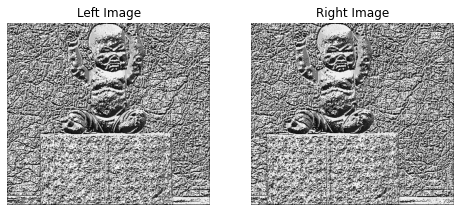

In [ ]:
iL_LBP = LBP_transform(imgL, 8, 1)
iR_LBP = LBP_transform(imgR, 8, 1)

plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Left Image')
plt.imshow(iL_LBP / np.max(iL_LBP), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Right Image')
plt.imshow(iR_LBP / np.max(iR_LBP), cmap = 'gray')

## LTP

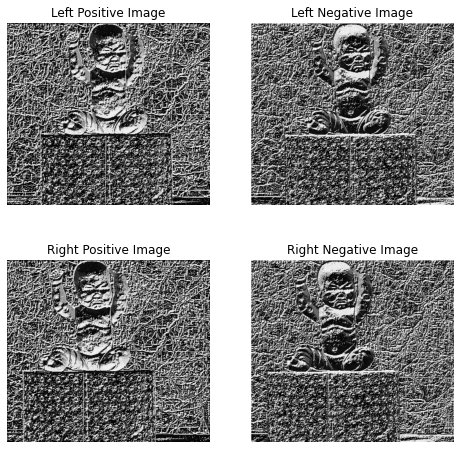

In [ ]:
iL_LTP = LTP_transform(imgL, 3, 1.0)
iR_LTP = LTP_transform(imgR, 3, 1.0)

plt.figure(figsize = (8, 8))

plt.subplot(2, 2, 1)
plt.axis('off')
plt.title('Left Positive Image')
plt.imshow(iL_LTP[..., 0] / np.max(iL_LTP[..., 0]), cmap = 'gray')

plt.subplot(2, 2, 2)
plt.axis('off')
plt.title('Left Negative Image')
plt.imshow(iL_LTP[..., 1] / np.max(iL_LTP[..., 1]), cmap = 'gray')

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title('Right Positive Image')
plt.imshow(iR_LTP[..., 0] / np.max(iR_LTP[..., 0]), cmap = 'gray')

plt.subplot(2, 2, 4)
plt.axis('off')
plt.title('Right Negative Image')
plt.imshow(iR_LTP[..., 1] / np.max(iR_LTP[..., 1]), cmap = 'gray')

## LDP

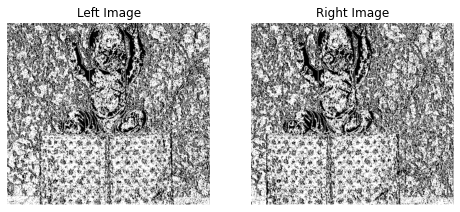

In [ ]:
iL_LDP = LDP_transform(imgL)
iR_LDP = LDP_transform(imgR)

plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Left Image')
plt.imshow(iL_LDP / np.max(iL_LDP), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Right Image')
plt.imshow(iR_LDP / np.max(iR_LDP), cmap = 'gray')

## LTrP

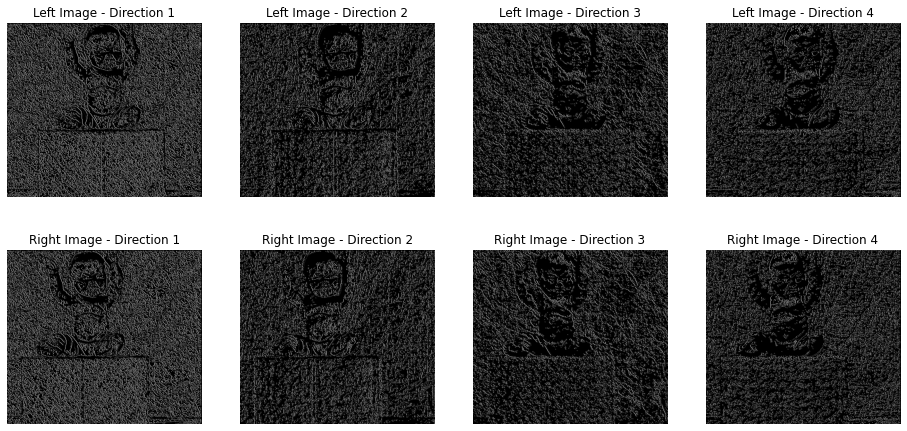

In [ ]:
iL_LTrP = LTrP_transform(imgL)
iR_LTrP = LTrP_transform(imgR)

plt.figure(figsize = (16, 16))

plt.subplot(4, 4, 1)
plt.axis('off')
plt.title('Left Image - Direction 1')
plt.imshow(iL_LTrP[..., 0] / np.max(iL_LTrP[..., 0]), cmap = 'gray')

plt.subplot(4, 4, 2)
plt.axis('off')
plt.title('Left Image - Direction 2')
plt.imshow(iL_LTrP[..., 1] / np.max(iL_LTrP[..., 1]), cmap = 'gray')

plt.subplot(4, 4, 3)
plt.axis('off')
plt.title('Left Image - Direction 3')
plt.imshow(iL_LTrP[..., 2] / np.max(iL_LTrP[..., 2]), cmap = 'gray')

plt.subplot(4, 4, 4)
plt.axis('off')
plt.title('Left Image - Direction 4')
plt.imshow(iL_LTrP[..., 3] / np.max(iL_LTrP[..., 3]), cmap = 'gray')

plt.subplot(4, 4, 5)
plt.axis('off')
plt.title('Right Image - Direction 1')
plt.imshow(iR_LTrP[..., 0] / np.max(iR_LTrP[..., 0]), cmap = 'gray')

plt.subplot(4, 4, 6)
plt.axis('off')
plt.title('Right Image - Direction 2')
plt.imshow(iR_LTrP[..., 1] / np.max(iR_LTrP[..., 1]), cmap = 'gray')

plt.subplot(4, 4, 7)
plt.axis('off')
plt.title('Right Image - Direction 3')
plt.imshow(iR_LTrP[..., 2] / np.max(iR_LTrP[..., 2]), cmap = 'gray')

plt.subplot(4, 4, 8)
plt.axis('off')
plt.title('Right Image - Direction 4')
plt.imshow(iR_LTrP[..., 3] / np.max(iR_LTrP[..., 3]), cmap = 'gray')

## SLBP

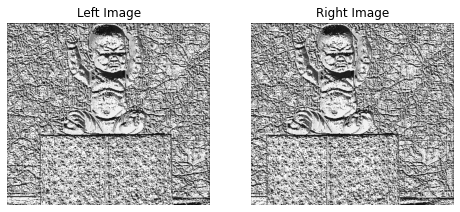

In [ ]:
iL_SLBP = SLBP_transform(imgL)
iR_SLBP = SLBP_transform(imgR)

plt.figure(figsize = (8, 8))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Left Image')
plt.imshow(iL_SLBP / np.max(iL_SLBP), cmap = 'gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Right Image')
plt.imshow(iR_SLBP / np.max(iR_SLBP), cmap = 'gray')

## Hamming distance

In [ ]:
# d = 8
# m = hamming_distance(iL_LBP, iR_LBP, d)

# plt.figure(figsize = (50, 50))
# for i in range(d):
#   plt.subplot(8, 1, i+1)
#   plt.axis('off')
#   plt.title(f'dist = {i + 1}')
#   plt.imshow(m[..., i] / np.max(m[..., i]), cmap = 'gray')
# plt.show()

## Semi-Global Paths

In [ ]:
results = []
for iL, iR in tqdm(zip([iL_LBP, iL_SLBP, iL_LTP, iL_LDP, iL_LTrP],
                       [iR_LBP, iR_SLBP, iR_LTP, iR_LDP, iR_LTrP])):
  img = semi_global_path_cost(iL, iR, maximum_disparity = 80)
  img_ = np.sum(img, axis = -1)
  disparity = np.argmin(img_, axis = -1)
  results.append(disparity)

nor = [(f - np.min(f)) / (np.max(f) - np.min(f)) * 255 for f in results]
filter = [cv.medianBlur(np.uint8(r), 9) for r in nor]

5it [03:02, 36.58s/it]


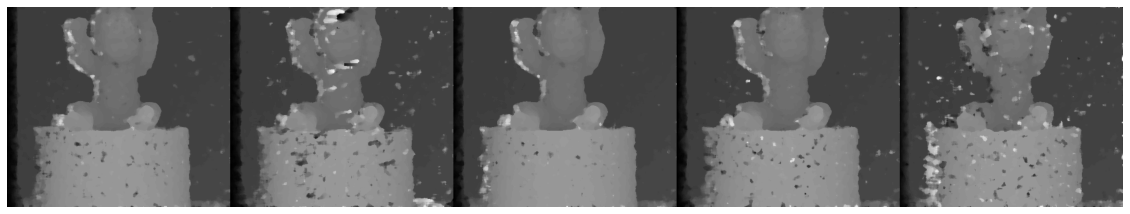

In [ ]:
stack = np.hstack(filter)

# plt.axis('off')
plt.figure(figsize = (20, 20))
plt.axis('off')
plt.imshow(stack,cmap = 'gray')
plt.show()